# Fashion Recommendation System using Image Features
A concise project that builds a fashion recommender using computer vision. We extract visual features (color, texture, style) from images with a pre-trained CNN, compute similarities, and return top-N similar or complementary items—all implemented in Python.

<div align="center">
<img src="https://media.istockphoto.com/id/665117072/photo/fashion-designer.jpg?s=612x612&w=0&k=20&c=H7EPV1CY2IhKaIYusp8krV1l0Mj9WVETBdw9dS4zfq8=" />
</div>

## Understanding the Process We Follow
Building a fashion recommendation system using image features involves several key steps, leveraging both computer vision and machine learning techniques. Below is a detailed process you can follow to build a fashion recommendation system using image features:

1. Assemble a diverse dataset of fashion items. This dataset should include a wide variety of items with different colours, patterns, styles, and categories.
2. Ensure all images are in a consistent format (e.g., JPEG, PNG) and resolution.
3. Implement a preprocessing function to prepare images for feature extraction.
4. Choose a pre-trained CNN model such as VGG16, ResNet, or InceptionV3. These models, pre-trained on large datasets like ImageNet, are capable of extracting powerful feature representations from images.
5. Pass each image through the CNN model to extract features.
6. Define a metric for measuring the similarity between feature vectors. 
7. Rank the dataset images based on their similarity to the input image and recommend the top N items that are most similar.
8. Implement a final function that encapsulates the entire process from pre-processing an input image, extracting features, computing similarities, and outputting recommendations.

So, the process starts with collecting a dataset of images based on fashionable outfits. I found an ideal dataset for this task. You can download the dataset from [here](https://statso.io/wp-content/uploads/2025/07/de18b-women-fashion.zip).

## 1. Importing Libraries
First, let’s import the necessary libraries for data manipulation, visualization, and deep learning.

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import glob
from IPython.display import Image as IPythonImage
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from scipy.spatial.distance import cosine

import  os
import warnings

### Configuration
Let's configure the necessary settings.
- Ignore warnings for cleaner output.
- Set default figure size to 12x8 inches for plots.
- Use seaborn's 'darkgrid' style for improved plot aesthetics.
- Set the TensorFlow logging level to avoid the warnings
- Set the random seed for reproducibility

In [4]:
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style('darkgrid')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.random.set_seed(42)

## 2. Data Loading
First, we will download the dataset and unzip it.

In [6]:
# If you are already downloaded the dataset, you can skip this step.
!wget https://statso.io/wp-content/uploads/2025/07/de18b-women-fashion.zip

--2025-09-17 15:39:22--  https://statso.io/wp-content/uploads/2025/07/de18b-women-fashion.zip
Resolving statso.io (statso.io)... 192.0.78.25, 192.0.78.24
Connecting to statso.io (statso.io)|192.0.78.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8789660 (8.4M) [application/zip]
Saving to: ‘de18b-women-fashion.zip’

de18b-women-fashion 100%[===================>]   8.38M  1.96MB/s    in 4.9s    

2025-09-17 15:39:30 (1.72 MB/s) - ‘de18b-women-fashion.zip’ saved [8789660/8789660]



In [7]:
# If you are already unzipped the dataset, you can skip this step.
!unzip -q de18b-women-fashion.zip

In [9]:
os.listdir('./women fashion/')[:10]

['tight-fitting, off-the-shoulder white dress 2.jpg',
 'blue dress with a floral pattern.jpg',
 'classic black slip dress with a midi length.jpg',
 'sparkling, fitted dress.jpeg',
 'black jumpsuit with a diagonal stripe of glittering material running across the body.jpg',
 'long, flowing dress with a full skirt.jpg',
 'light green, short dress with lace detailing around the waist and the edges of the sleeves and hem.jpg',
 'sleeveless dress adorned with pink sequins.jpg',
 'sparkling, fitted dress 2.jpeg',
 'vibrant blue and a neutral tone adorned with colorful floral patterns.jpg']

In [ ]:
# Let's assign the files in the folder to a variable and combine with the correct parent path.
extracted_files = os.listdir('./women fashion/')
extracted_files = [os.path.join('./women fashion/', file) for file in extracted_files]

Now, let's take a look at any random image in the dataset.

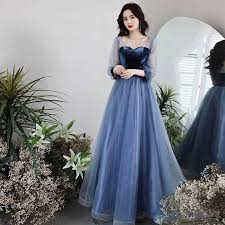

In [28]:
IPythonImage(extracted_files[10])

Now, we will create a list of all image file paths that will be used later in extracting the features from every image in the dataset

In [34]:
image_files_dir = './women fashion'
image_files = [file for file in glob.glob(os.path.join(image_files_dir, '*.*')) if file.endswith(('jpg', 'png', 'jpeg', 'webp'))]

In [36]:
image_files[:10]

['./women fashion/tight-fitting, off-the-shoulder white dress 2.jpg',
 './women fashion/blue dress with a floral pattern.jpg',
 './women fashion/classic black slip dress with a midi length.jpg',
 './women fashion/sparkling, fitted dress.jpeg',
 './women fashion/black jumpsuit with a diagonal stripe of glittering material running across the body.jpg',
 './women fashion/long, flowing dress with a full skirt.jpg',
 './women fashion/light green, short dress with lace detailing around the waist and the edges of the sleeves and hem.jpg',
 './women fashion/sleeveless dress adorned with pink sequins.jpg',
 './women fashion/sparkling, fitted dress 2.jpeg',
 './women fashion/vibrant blue and a neutral tone adorned with colorful floral patterns.jpg']

Here, the glob module gathers image file paths from the target folder. The glob.glob call matches any filename using the *.* pattern, and the list comprehension narrows the results to paths ending with common image extensions (.jpg, .png, .jpeg, .webp).

## 3. Feature Extraction
Let's extract the features from the images with VGG16 model.

In [38]:
# First, we will load the VGG16 model.
base_model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=base_model.input, outputs=base_model.output)

I0000 00:00:1758114016.170314    6113 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1751 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [44]:
# Define functions to preprocess images and extract features.
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

def extract_features(model, preprocessed_image):
    features = model.predict(preprocessed_image, verbose=0)
    features = features.flatten()
    features = features / np.linalg.norm(features)
    return features

In [ ]:
# Extract features from the images.
all_features = []
all_image_paths = []

for image_file in tqdm(image_files):
    preprocessed_image = preprocess_image(image_file)
    features = extract_features(model, preprocessed_image)
    all_features.append(features)
    all_image_paths.append(image_file)

100%|██████████| 96/96 [00:14<00:00,  6.73it/s]


The code above extracts visual descriptors with VGG16, a CNN pre-trained on ImageNet.
We load VGG16 without the classification head `(include_top=False)` so it outputs feature maps.
For each path in image_files, the image is resized to 224x224, converted to an array, and preprocessed to the network’s expected format before inference.

The network outputs are flattened and L2-normalized to form a single feature vector per image.
We accumulate these vectors in all_features and keep the corresponding file paths in
all_image_paths. This produces a clean feature index we can later use for similarity search.

Now, let's write a function to search for similar images.

## 4. Similarity Search
Let's search for similar images.

In [70]:
# Define a function to search for similar images.
def search_similar_images(query_image_path, all_features, all_image_paths, model, top_n=5):
    # preprocess the input image and extract features
    query_image = preprocess_image(query_image_path)
    query_features = extract_features(model, query_image)

    # calculate the cosine similarity between the query features and all the features in the dataset
    similarities = [1 - cosine(query_features, feature) for feature in all_features]
    similar_indices = np.argsort(similarities)[-top_n - 1:]

    # filter out the input image from the similar_indices
    similar_indices = [idx for idx in similar_indices if idx != all_image_paths.index(query_image_path)]

    # display the input image
    plt.figure(figsize=(15, 10))
    plt.subplot(1, top_n + 1, 1)
    plt.imshow(image.load_img(query_image_path))
    plt.title('Query Image')
    plt.axis('off')

    # display the similar images
    for i, idx in enumerate(similar_indices):
        plt.subplot(1, top_n + 1, i + 2)
        plt.imshow(image.load_img(all_image_paths[idx]))
        plt.title(f'Recommended Image {i + 1}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

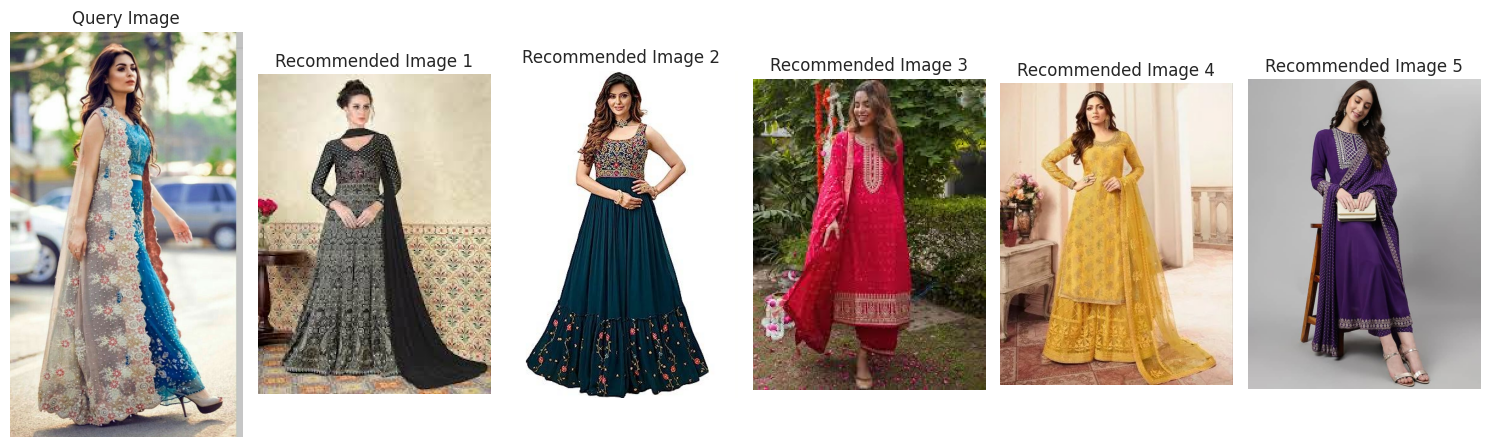

In [80]:
search_similar_images(image_files[9], all_features, all_image_paths, model, top_n=5)

## 5. Conclusion
This notebook demonstrated a simple, end‑to‑end image‑based fashion recommendation pipeline.

Key features implemented:
- Dataset handling and inspection with reproducible setup
- Feature extraction using a pre‑trained VGG16 backbone (include_top=False)
- L2‑normalized embeddings for stable similarity comparisons
- Cosine‑similarity retrieval and visualization of top‑N similar items
- Clear, modular helpers for preprocessing and feature extraction

Potential future improvements:
- Replace VGG16 with stronger encoders (e.g., ResNet50, EfficientNet, CLIP/ViT) for richer embeddings
- Add approximate nearest neighbor search (FAISS/ScaNN) for scalability to millions of images
- Incorporate metadata (category, color tags, price) for hybrid content + metadata reranking
- Learn a task‑specific metric via contrastive/fine‑tuning on outfit similarity labels
- Add data augmentations and better preprocessing tailored to fashion (e.g., background removal)
- Deploy as an API or interactive UI for real‑time recommendations
- Cache embeddings and maintain an index that updates incrementally as the catalog changes